# A/B-тестирование

## Постановка задачи

Задача — провести оценку результатов A/B-теста. В распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

- Оценить корректность проведения теста
- Проанализировать результаты теста

Чтобы оценить корректность проведения теста, проверить:

- пересечение тестовой аудитории с конкурирующим тестом,
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

## <a id='task'> Техническое задание </a>

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

## Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## План 

1. Описать цели исследования
2. Исследовать данные:
    * Требуется ли преобразование типов?
    * Присутствуют ли пропущенные значения и дубликаты? Если да, то какова их природа?
3. Оценить корректность проведения теста. Обратить внимание на:
    * Соответствие данных требованиям технического задания. Проверить корректность всех пунктов технического задания
    * Время проведения теста. Убедиться, что оно не совпадает с маркетинговыми и другими активностями
    * Аудиторию теста. Удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверить равномерность распределения пользователей по тестовым группам и правильность их формирования
4. Провести исследовательский анализ данных:
    * Количество событий на пользователя одинаково распределены в выборках?
    * Как число событий в выборках распределено по дням?
    * Как меняется конверсия в воронке в выборках на разных этапах?
    * Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?
5. Провести оценку результатов A/B-тестирования:
    * Что можно сказать про результаты A/B-тестирования?
    * Проверить статистическую разницу долей z-критерием
6. Описать выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Сделать общее заключение о корректности проведения теста

## Цели исследования

1. Оценить корректность проведения теста
2. Проанализировать результаты теста

## Ход исследования

1. [Загрузка данных](#start) 
2. [Изучение общей информации и предобработка данных](#preprocessing)
3. [Оценка корректности проведения теста](#test)
4. [Анализ данных](#analysis)
5. [Оценка результатов A/B-тестирования](#A_B)
6. [Выводы](#conclusion)

### <a id='start'> Загрузка данных </a>  

In [1]:
pip install cufflinks

Note: you may need to restart the kernel to use updated packages.


In [2]:
# импортируем все библиотеки, которые будут нужны для выполнения исследования

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math as mth
from scipy import stats as st
from datetime import datetime as dt
from datetime import timedelta
import plotly.express as px
from plotly import graph_objects as go
from statsmodels.stats.proportion import proportions_ztest
import cufflinks as cf

In [3]:
# откроем рабочие файлы

try:
    final_ab_events_raw = pd.read_csv('/datasets/final_ab_events.csv')
except:
    final_ab_events_raw = pd.read_csv('https://disk.yandex.ru/d/pgKgZ9lRp0Enwg')
    
try:
    ab_project_marketing_events_raw = pd.read_csv('/datasets/ab_project_marketing_events.csv')
except:
    ab_project_marketing_events_raw = pd.read_csv('https://disk.yandex.ru/d/ZVC7GUYYckKnGQ')
    
try:
    final_ab_new_users_raw = pd.read_csv('/datasets/final_ab_new_users.csv')
except:
    final_ab_new_users_raw = pd.read_csv('https://disk.yandex.ru/d/Qrto8Gerpu424g')
    
try:
    final_ab_participants_raw = pd.read_csv('/datasets/final_ab_participants.csv')
except:
    final_ab_participants_raw = pd.read_csv('https://disk.yandex.ru/d/nhGUR3ZkNIG4VA')

In [4]:
# создадим копии датафреймов

final_ab_events = final_ab_events_raw.copy(deep=True)
ab_project_marketing = ab_project_marketing_events_raw.copy(deep=True)
final_ab_new_users = final_ab_new_users_raw.copy(deep=True)
final_ab_participants = final_ab_participants_raw.copy(deep=True)

### <a id='preprocessing'> Изучение общей информации и предобработка данных </a>

In [5]:
# создадим функцию для вывода предобработки данных

def info(data):
    # посмотрим общую информацию о файле 
    print('Общая информация о датафрейме:')
    data.info()
    
    # выведем на экран 5 строчек таблицы
    
    pd.options.display.max_colwidth = 100
    pd.set_option('display.max_columns', 20)
    display(data.head(5))
    
    # посчитаем количество пропущенных значений

    print('Количество пропущенных значений:')
    print(data.isna().sum().sort_values(ascending=False))
    
    # посчитаем количество полных дубликатов

    print()
    print('Количество полных дубликатов: ', data.duplicated().sum())

In [6]:
# рассмотрим датафрейм final_ab_events

info(final_ab_events)

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Количество пропущенных значений:
details       377577
user_id            0
event_dt           0
event_name         0
dtype: int64

Количество полных дубликатов:  0


In [7]:
final_ab_events.query('event_name == "purchase"').isna().sum()

user_id       0
event_dt      0
event_name    0
details       0
dtype: int64

> В колонке `details` указывались дополнительные данные, такие как сумма покупки. В событиях *purchase* пропусков нет, следовательно, с данными все корректно.

In [8]:
# приведем дату в колонке event_dt к нужному типу

final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])

In [9]:
# рассмотрим датафрейм ab_project_marketing

info(ab_project_marketing)

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


Количество пропущенных значений:
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

Количество полных дубликатов:  0


In [10]:
# приведем дату в колонках start_dt и finish_dt к нужному типу

ab_project_marketing['start_dt'] = pd.to_datetime(ab_project_marketing['start_dt'])
ab_project_marketing['finish_dt'] = pd.to_datetime(ab_project_marketing['finish_dt'])

In [11]:
# рассмотрим датафрейм final_ab_new_users

info(final_ab_new_users)

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Количество пропущенных значений:
user_id       0
first_date    0
region        0
device        0
dtype: int64

Количество полных дубликатов:  0


In [12]:
# приведем дату в колонке first_date к нужному типу

final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

In [13]:
# рассмотрим датафрейм final_ab_participants

info(final_ab_participants)

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Количество пропущенных значений:
user_id    0
group      0
ab_test    0
dtype: int64

Количество полных дубликатов:  0


> **Вывод:** 
1. Данные из датасетов были изучены, проведена их предобработка
2. Полных дубликатов в датасетах обнаружено не было
3. Пропуски были обнаружены в датасете *final_ab_events* для событий, не являющимися покупками. Это корректно
4. Столбцы, содержащие даты, были переведен в формат datetime

### <a id='test'> Оценка корректности проведения теста </a>

#### Соответствие данных требованиям [технического задания](#task) . Проверить корректность всех пунктов [технического задания](#task)

**Посмотрим, информация о скольких АВ тестах содержится в данных, проверим пересечение пользователей между тестами (если их несколько) и группами изучаемого теста**

In [14]:
# посмотрим, какие А/В-тесты содержатся в файле final_ab_participants

final_ab_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [15]:
# в файле final_ab_new_users оставим только тех пользователей, которые пришли c 2020-12-07 до 2020-12-21 включительно

new_users = final_ab_new_users.query('"2020-12-07 00:00:00" <= first_date <= "2020-12-21 23:59:59"')

In [16]:
# соединим датафреймы final_ab_participants, new_users и final_ab_events

final_data = final_ab_participants.merge(new_users, on='user_id', how='left')
final_data = final_data.merge(final_ab_events, on='user_id', how='left')

In [17]:
# сформируем датасеты для двух А/В-тестов

test_1 = final_data.query('ab_test == "recommender_system_test"')
test_2 = final_data.query('ab_test == "interface_eu_test"')
test_2 = test_2[test_2['event_dt'].between('2020-12-07', '2021-01-04')]

In [18]:
# создадим датафрейм, в котором отражены пользователи, участвовашие в обоих тестах в одно и то же время

test_check = test_1.merge(test_2, on='user_id')

In [19]:
user_list = test_check['user_id'].unique().tolist()

In [20]:
# сформируем датафрейм, в котором не содержатся пользователи, участвовавшие в обоих тестах

ab_participants = final_ab_participants.query('user_id not in @user_list')
ab_participants = ab_participants.query('ab_test == "recommender_system_test"')

In [21]:
# создадим общий датафрейм

final_data_checked = ab_participants.merge(new_users, on='user_id', how='left')
final_data_checked = final_data_checked.merge(final_ab_events, on='user_id', how='left')
final_data_checked['event_date'] = final_data_checked['event_dt'].dt.date
final_data_checked = final_data_checked.query('region == "EU"')

In [22]:
last_event_date = final_data_checked.groupby('user_id').agg({'event_dt':'max'}).rename(columns={'event_dt':'last_event_date'})
final_data_checked = final_data_checked.merge(last_event_date, on='user_id', how='left')

In [23]:
# добавим lifetime для пользователей

final_data_checked['lifetime'] = (
    (final_data_checked['last_event_date'] - final_data_checked['first_date'])/np.timedelta64(1, 'D')
).round(0)

In [24]:
final_data_checked_lifetime = final_data_checked.query('lifetime == 14')
print('Количество пользователей, для которых с момента регистрации до последнего действия прошло ровно 14 дней:',
      final_data_checked_lifetime['user_id'].nunique()
     )

Количество пользователей, для которых с момента регистрации до последнего действия прошло ровно 14 дней: 64


> По ТЗ дата остановки теста - 2021-01-04. В наших данных последнее событие было совершено 2020-12-30, т.е. фактически тест был завершен раньше. Таким образом, для ряда пользователей мы не достигли 14 дней с момента регистрации. Также для большой части группы не наблюдалось совершения каких-либо событий с момента регистрации.

In [25]:
# проверим равномерность распределения пользователей по тестовым группам и правильность их формирования

group_A = final_data_checked.query('group == "A"')
N_group_A = group_A['user_id'].nunique()
print('Количество участников в группе А:', N_group_A)

group_B = final_data_checked.query('group == "B"')
N_group_B = group_B['user_id'].nunique()
print('Количество участников в группе В:', N_group_B)

Количество участников в группе А: 2969
Количество участников в группе В: 2495


In [26]:
# проверим пересечение пользователей между группами изучаемого теста

group_check = group_A.merge(group_B, on='user_id')
group_check

,user_id,group_x,ab_test_x,first_date_x,region_x,device_x,event_dt_x,event_name_x,details_x,event_date_x,...,ab_test_y,first_date_y,region_y,device_y,event_dt_y,event_name_y,details_y,event_date_y,last_event_date_y,lifetime_y


> Пересечений между группами нет

In [27]:
ab_project_marketing.query('start_dt >= "2020-12-07" and finish_dt <= "2021-01-04"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


> **Вывод:** Получен датасет, в котором содержится информация о пользователях из ЕС, участвовавших только в тесте, связанном с внедрением улучшенной рекомендательной системы в период с 7 декабря по 4 января 2020. Согласно данным, 25 декабря началась рождественская рекламная компания. Однако у нас нет данных, как имеено она проводилась. Возможно пользователи, участвующие в тесте, не были в него вовлечены. Поэтому фильтровать пользователей исходя из пересечения с этим событиям не будем.

#### Проверить, все ли пользователи, зарегистрированные в тесте, совершали за период проведения теста события. Если пользователи, которые не совершали события есть, то лучше подсчитать их количество, а также проверить их распределение между тестовой и контрольной группами.

In [28]:
# проверим, все ли пользователи, зарегистрированные в тесте, совершали за период проведения теста события

wtht_NA = final_data_checked.dropna(subset=['event_dt'])
user_event_list = wtht_NA['user_id'].unique().tolist()
count_user_event = final_data_checked.query('user_id not in @user_event_list')['user_id'].nunique()
print(f'Количество пользователей, которые не совершали события:', count_user_event)

Количество пользователей, которые не совершали события: 2870


> **Вывод:** В данных содержится информация по 2870 пользователям, которые не совершали никаких событий. Причиной отсутствия событий у ряда пользователей может быть естественная конверсия, т.е. после регистрации пользователи потеряли интерес к ресурсу и не стали заходить на этап логин. Или, возможно, что это была какая-то ошибка в сборе данных, и у нас нет части данных. 

#### Посмотрим детальнее на пользователей без событий: как они распределены по группам теста и какая была динамика их регистрации

In [29]:
print(f'Количество пользователей в группе А, которые не совершали события:', 
      group_A.query('user_id not in @user_event_list')['user_id'].nunique()
     )
print(f'Количество пользователей в группе B, которые не совершали события:', 
      group_B.query('user_id not in @user_event_list')['user_id'].nunique()
     )

Количество пользователей в группе А, которые не совершали события: 1030
Количество пользователей в группе B, которые не совершали события: 1840


In [30]:
users_per_date = (
    final_data_checked.pivot_table(
        index = 'first_date',
        values = 'user_id',
        aggfunc = 'nunique'
    ).rename(columns={'user_id':'users_all'})
    .sort_values(by='first_date')
    .reset_index()
)

users_per_date_NA = (
    wtht_NA.pivot_table(
        index = 'first_date',
        values = 'user_id',
        aggfunc = 'nunique'
    ).rename(columns={'user_id':'users_with_events'})
    .sort_values(by='first_date')
    .reset_index()
)

comparison = users_per_date.merge(users_per_date_NA, on='first_date').set_index('first_date')

In [31]:
cf.set_config_file(offline=True)

comparison.iplot(kind='bar', barmode='stack', title='Количество новых пользователей в разбивке по дате')

> По распределению пользователей нельзя сказать, что была какая-либо ошибка в сборе данных

In [32]:
# проверим процент новых пользователей из региона EU в начальных данных (до очистки)

test_users_by_region = test_1.groupby('region').agg({'user_id':'nunique'}).reset_index()
test_users_by_region.columns = ['region', 'test_user_count']

In [33]:
all_users_by_region = new_users['region'].value_counts().to_frame().reset_index()
all_users_by_region.columns = ['region', 'all_user_count']

region_info = test_users_by_region.merge(all_users_by_region, on='region', how='left')
region_info['share'] = (region_info['test_user_count'] / region_info['all_user_count'] * 100).round(1)

region_info

,region,test_user_count,all_user_count,share
0,APAC,72,2883,2.5
1,CIS,55,2900,1.9
2,EU,6351,42340,15.0
3,N.America,223,8347,2.7


In [34]:
# проверим процент новых пользователей из региона EU после очистки данных

test_users_by_region_checked = (
    final_data_checked.query('region == "EU"')
                    .groupby('region')
                    .agg({'user_id':'nunique'})
                    .reset_index()
)
test_users_by_region_checked.columns = ['region', 'test_user_count']

region_info_checked = test_users_by_region_checked.merge(all_users_by_region, on='region', how='left')
region_info_checked['share'] = (region_info_checked['test_user_count'] / region_info_checked['all_user_count'] * 100).round(1)

region_info_checked

,region,test_user_count,all_user_count,share
0,EU,5464,42340,12.9


In [35]:
print('Количество участников теста: ', final_data_checked['user_id'].nunique())

Количество участников теста:  5464


> **Вывод:** После удаления участников одновремнно двух тестов доля пользователей из EU сократилась до 12.9%. Количество участников теста 5464.

In [36]:
diff = (1 - N_group_B/N_group_A)
print(f'Разница в количестве участников в группе А и В: {diff:.2%}')

Разница в количестве участников в группе А и В: 15.96%


#### Проверим конверсию на этапах <a id='funnel'> воронки </a>. Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
* **конверсии в просмотр карточек товаров — событие `product_page`,**
* **просмотры корзины — `product_cart`,**
* **покупки — `purchase`.**

In [37]:
# исследуем конверсию в группах на разных этапах

group_A_events = group_A.drop_duplicates(['user_id', 'event_name'])['event_name'].value_counts().to_frame().reset_index()
group_A_events = group_A_events.reindex([0,1,3,2])
group_B_events = group_B.drop_duplicates(['user_id', 'event_name'])['event_name'].value_counts().to_frame().reset_index()
group_B_events = group_B_events.reindex([0,1,3,2])

In [38]:
# построим воронку

fig = go.Figure()

fig.add_trace(go.Funnel(
    name='group B',
    y = group_B_events['index'],
    x = group_B_events['event_name'].to_list(),
    textposition = "auto",
    textinfo = "value+percent previous+ percent initial"
    )) 
fig.add_trace(go.Funnel(
    name='group A',
    y = group_A_events['index'].to_list(),
    x = group_A_events['event_name'].to_list() ,
    textposition = "inside",
    textinfo = "value+percent previous+ percent initial"
    ))
fig.update_layout(title_text='Воронка по группам А/В')

fig.show()

In [39]:
group_B_events = group_B_events.rename(columns={'event_name' : 'total_events_B'})
group_A_events = group_A_events.rename(columns={'event_name' : 'total_events_A'})

CR = group_B_events.merge(group_A_events, on='index')
CR['CR_B, %'] = ((CR['total_events_B']/CR['total_events_B'].shift(1))*100).round(1)
CR['CR_A, %'] = ((CR['total_events_A']/CR['total_events_A'].shift(1))*100).round(1)


CR['diff'] = ((CR['CR_B, %']/CR['CR_A, %'] - 1)*100).round(1)
CR

,index,total_events_B,total_events_A,"CR_B, %","CR_A, %",diff
0,login,655,1939,NaN,NaN,NaN
1,product_page,367,1265,56.0,65.2,-14.1
2,product_cart,184,589,50.1,46.6,7.5
3,purchase,191,613,103.8,104.1,-0.3


1. Конверсия в просмотр карточек товаров для группы А 65.2%, а для группы В - 56%
2. Конверсия в просмотр корзины для группы А 46.6% , а для группы В - 50.1%
3. Конверсия в покупки для группы А 104.1%, а для группы В - 103.8%

> **Вывод:** 
Таким образом, ожидаемого увеличения конверсии для всех этапов на 10% по группе В не наблюдается.

Для групп А и В наблюдается большое количество переходов со страницы товара сразу на оплату, минуя просмотр корзины. Если смотреть на воронку, то мы видим, что конверсия в переход между событиями "просмотр корзины" и "покупка" больше 100%. Это может быть объяснено наличием кнопки "Купить сразу". 

#### <a id='tz'> Общий вывод </a>
Тест проведен не корректно (не соответствует ТЗ), поскольку:
1. Количество пользователей меньше 6000 (а именно 5464)
2. 2870 пользователей не совершали никаких действий в период теста
3. Последняя дата совершения действий - 30 декабря, соответственно не для всех пользоватлей прошло 14 дней с момента регистрации
4. Контрольная и тестовые группы не одинаковы по размерам (2969 пользователей в группе А и 2495 - в группе В)
5. Аудитория - 12.9% из EU вместо заявленых 15.0%
6. Улучшения каждой метрики не менее, чем на 10%, не наблюдается

### <a id='analysis'> Анализ данных </a>

#### Количество событий на пользователя одинаково распределены в выборках?

In [40]:
event_mean_A = (
    group_A.pivot_table(index=['user_id', 'event_name'],
                        values='event_dt',
                        aggfunc='count')
            .reset_index()
            .groupby('event_name')
            .agg({'event_dt':'mean'})
            .reset_index()
            .round(2)
)
event_mean_B = (
    group_B.pivot_table(index=['user_id', 'event_name'],
                        values='event_dt',
                        aggfunc='count')
            .reset_index()
            .groupby('event_name')
            .agg({'event_dt':'mean'})
            .reset_index()
            .round(2)
)
fig = go.Figure(data=[
    go.Bar(name='Group A', x=event_mean_A['event_name'].to_list(),
           y=event_mean_A['event_dt'].to_list(),
           text=event_mean_A['event_dt'].to_list(),
           textposition='auto'),
    go.Bar(name='Group B', x=event_mean_B['event_name'].to_list(),
           y=event_mean_B['event_dt'].to_list(),
           text=event_mean_B['event_dt'].to_list(),
           textposition='auto')
])

fig.update_layout(barmode='group', title='График среднего количества взаимодействий с карточкой на одного пользователя')

fig.show()

In [41]:
event_per_user_A = wtht_NA.query('group == "A"').pivot_table(index=['user_id'],
                                                              values='event_name',
                                                              aggfunc='count').reset_index()
event_per_user_B = wtht_NA.query('group == "B"').pivot_table(index=['user_id'],
                                                              values='event_name',
                                                              aggfunc='count').reset_index()

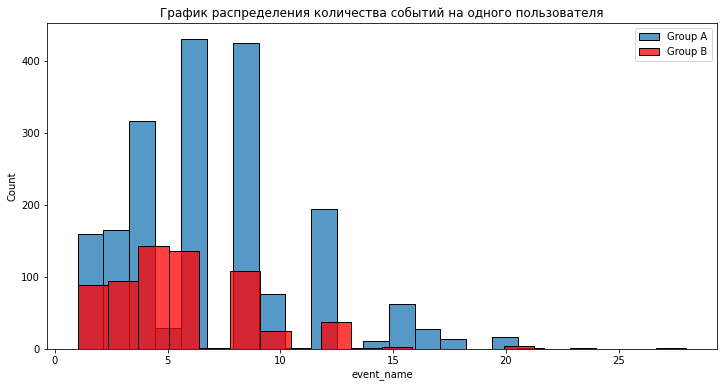

In [42]:
plt.figure(figsize=(12, 6))
sns.histplot(event_per_user_A['event_name'], bins=20)
sns.histplot(event_per_user_B['event_name'],bins=20, color = 'r')
plt.legend(labels = ('Group A', 'Group B'))
plt.title('График распределения количества событий на одного пользователя')
plt.show()

> **Вывод:** 

По графику среднего количества взаимодействий с карточкой на одного пользователя видим, что по всем карточкам среднее число взаимодействий на одного пользователя у группы А лучше. 

На графике распределения количества событий на одного пользователя видим, что группа А в основном преобладает по количеству событий на пользователя.

Таким образом, выборки обладают различным распределением взаимодействий и разным средним количеством событий по карточке на одного пользователя.

#### Как число событий в выборках распределено по дням?

In [43]:
count_events_per_day_A = (
    wtht_NA.query('group == "A"')
            .pivot_table(
                index=['event_name','event_date'], 
                values='event_dt', 
                aggfunc='count')
            .reset_index()
            .rename(columns={'event_dt':'count_event'})
)

count_events_per_day_B = (
    wtht_NA.query('group == "B"')
            .pivot_table(
                index=['event_name','event_date'], 
                values='event_dt', 
                aggfunc='count')
            .reset_index()
            .rename(columns={'event_dt':'count_event'})
)

In [48]:
figA = px.bar(count_events_per_day_A, x='event_date', y='count_event', color='event_name')
figA.update_layout(title='Распределение событий по дням для Group A')
figA.for_each_trace(lambda t: t.update(name=t.name.split("=")[0]))
figA.show()

figB = px.bar(count_events_per_day_B, x='event_date', y='count_event', color='event_name')
figB.update_layout(title='Распределение событий по дням для Group В')
figB.for_each_trace(lambda t: t.update(name=t.name.split("=")[0]))
#figB.update_yaxes(range=(0,2000))
figB.show()

> **Вывод:**
1. Для обеих групп пиковая активность пользователей наблюдается 21 декабря
2. В группе В также наблюдается высокая активность 7,9 и 16 декабря
3. Самое большое количество покупок за период теста пользователи совершили 21 числа; было совершено 208 покупок в группе А и 47 - в группе В
4. Для обеих групп наблюдается спад активности с 22 декабря

#### Как меняется конверсия в воронке в выборках на разных этапах?

Воронка отражена в пункте [6.3.4](#funnel)  

> **Вывод:** Для групп А и В наблюдается большое количество переходов со страницы товара сразу на оплату, минуя просмотр корзины. Если смотреть на воронку, то мы видим, что конверсия в переход между событиями "просмотр корзины" и "покупка" больше 100%. Это может быть объяснено наличием кнопки "Купить сразу". 

#### Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

1. Необходимо учесть, что у нас не выполняются условия ТЗ (см. пункт [6.3.5](#tz))
2. В данных содержится информация по 2870 пользователям, которые не совершали никаких событий. Причиной отсутствия событий у ряда пользователей может быть естественная конверсия, т.е. после регистрации пользователи потеряли интерес к ресурсу и не стали заходить на этап логин. Или, возможно, что это была какая-то ошибка в сборе данных, и у нас нет части данных.
3. Согласно данным, 25 декабря началась рождественская рекламная компания. Однако у нас нет данных, как имеено она проводилась. Возможно пользователи, участвующие в тесте, не были в него вовлечены.

### <a id='A_B'> Оценка результатов A/B-тестирования </a>

#### Проверить статистическую разницу долей z-критерием

In [45]:
users_count_by_group = wtht_NA.groupby('group')['user_id'].nunique()
users_by_events = final_data_checked.pivot_table(
    index='group', columns='event_name', values='user_id', aggfunc='nunique'
).reset_index()
users_by_events['user_count'] = users_by_events['group'].apply(lambda x: users_count_by_group.loc[x])
users_by_events = users_by_events.set_index('group')
users_by_events = users_by_events[['login', 'product_page',
                                   'product_cart', 'purchase', 'user_count']].T
users_by_events

group,A,B
event_name,,
login,1939,655
product_page,1265,367
product_cart,589,184
purchase,613,191
user_count,1939,655


In [46]:
steps = np.array(['login',
                  'product_page',
                  'product_cart',
                  'purchase'])

**Гипотезы о равенстве долей пользователей на шагах в группах A и В:**
* H0 - доли пользователей, перешедших к шагу Х, в группах А и В равны
* Н1 - доли пользователей, перешедших к шагу Х, в группах А и В различны

In [47]:
# применим Z-test для проверки гипотезы о равенстве долей пользователей на шагах в группах A и В

alpha = 0.05/4 # критический уровень статистической значимости с поправкой Бонферрони

for i in range(len(steps)):
    print('Гипотеза о равенстве контрольных групп А и В на шаге', steps[i])
    
    # за успех считаем событие, когда пользователь перешел дальше по воронке
    
    successes = np.array([users_by_events['A'][i], users_by_events['B'][i]])
    
    # количество попыток - общее число пользователей в группе
    
    trials = np.array([users_by_events['A']['user_count'], users_by_events['B']['user_count']])

    stat, pval = proportions_ztest(successes, trials)
    print('P-value равно','{0:0.3f}'.format(pval))
    if pval < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 
    print()

Гипотеза о равенстве контрольных групп А и В на шаге login
P-value равно nan
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Гипотеза о равенстве контрольных групп А и В на шаге product_page
P-value равно 0.000
Отвергаем нулевую гипотезу: между долями есть значимая разница

Гипотеза о равенстве контрольных групп А и В на шаге product_cart
P-value равно 0.269
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Гипотеза о равенстве контрольных групп А и В на шаге purchase
P-value равно 0.240
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



/opt/conda/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:790: RuntimeWarning:

invalid value encountered in double_scalars



> **Вывод:**
* Тест можно остановить и считать успешным, поскольку мы видим, что по целевым признакам product_cart и purchase нет статистически значимой разницы. Следовательно, нет оснований считать изменения, связанные с внедрением улучшенной рекомендательной системы, успешными. 
* Для карточки product_page, мы отвергаем нулевую гипотезу, так как статистически значимая разница между выборками есть. Однако не в пользу группы В, т.к. она показала себя хуже (53.2% для группы В против 65.0% для группы А). Поэтому ожидаемого эффекта в качестве прироста конверсии по просмотру карточек в размере 10% не наблюдается. 

### Вывод

**В ходе выполнения проекта**:
1. **Была проведена предобработка данных, полных дубликатов найдено не было. Для столбцов с датами был изменен тип данных**
2. **Была проведена оценка корректности проведения А/В-теста**:
    * Количество пользователей меньше 6000 (а именно 5464)
    * 2870 пользователей не совершали никаких действий в период теста
    * Последняя дата совершения действий - 30 декабря, соответственно не для всех пользоватлей прошло 14 дней с момента регистрации
    * Контрольная и тестовые группы не одинаковы по размерам (2969 пользователей в группе А и 2495 - в группе В)
    * Аудитория - 12.9% из EU вместо заявленых 15.0%
    * Улучшения каждой метрики не менее, чем на 10%, не наблюдается

**Таким образом, тест был проведен не корректно**

3. **Проведен анализ данных**:
    * Выборки обладают различным распределением взаимодействий и разным средним количеством событий по карточке на одного пользователя, поскольку:
        * По графику среднего количества взаимодействий с карточкой на одного пользователя видно, что по всем карточкам среднее число взаимодействий на одного пользователя у группы А лучше. 
        * На графике распределения количества событий на одного пользователя видим, что группа А в основном преобладает по количеству событий на пользователя.
    * Для обеих групп пиковая активность пользователей наблюдается 21 декабря. В группе В также наблюдается высокая активность 7,9 и 16 декабря
    * Самое большое количество покупок за период теста пользователи совершили 21 числа; было совершено 208 покупок в группе А и 47 - в группе В
    * Для обеих групп наблюдается спад активности с 22 декабря
    * Для групп А и В наблюдается большое количество переходов со страницы товара сразу на оплату, минуя просмотр корзины. Если смотреть на воронку, то мы видим, что конверсия в переход между событиями "просмотр корзины" и "покупка" больше 100%. Это может быть объяснено наличием кнопки "Купить сразу"
4. В данных содержится информация по 2870 пользователям, которые не совершали никаких событий. Причиной отсутствия событий у ряда пользователей может быть естественная конверсия, т.е. после регистрации пользователи потеряли интерес к ресурсу и не стали заходить на этап логин. Или, возможно, что это была какая-то ошибка в сборе данных, и у нас нет части данных.
5. Согласно данным, 25 декабря началась рождественская рекламная компания. Однако у нас нет данных, как имеено она проводилась. Возможно пользователи, участвующие в тесте, не были в него вовлечены.
6. Тест можно остановить и считать успешным, поскольку мы видим, что по целевым признакам product_cart и purchase нет статистически значимой разницы. Следовательно, нет оснований считать изменения, связанные с внедрением улучшенной рекомендательной системы, успешными. 
    * Для карточки product_page, мы отвергаем нулевую гипотезу, так как статистически значимая разница между выборками есть. Однако не в пользу группы В, т.к. она показала себя хуже (53.2% для группы В против 65.0% для группы А). Поэтому ожидаемого эффекта в качестве прироста конверсии по просмотру карточек в размере 10% не наблюдается. 